In [2]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# nltk
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB , GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DooFromash\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df = pd.read_csv("./youtoxic_english_1000.csv")
df.head()

,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
0,Ugg2KwwX0V8-aXgCoAEC,04kJtp6pVXI,If only people would just take a step back and...,False,False,False,False,False,False,False,False,False,False,False,False
1,Ugg2s5AzSPioEXgCoAEC,04kJtp6pVXI,Law enforcement is not trained to shoot to app...,True,True,False,False,False,False,False,False,False,False,False,False
2,Ugg3dWTOxryFfHgCoAEC,04kJtp6pVXI,\nDont you reckon them 'black lives matter' ba...,True,True,False,False,True,False,False,False,False,False,False,False
3,Ugg7Gd006w1MPngCoAEC,04kJtp6pVXI,There are a very large number of people who do...,False,False,False,False,False,False,False,False,False,False,False,False
4,Ugg8FfTbbNF8IngCoAEC,04kJtp6pVXI,"The Arab dude is absolutely right, he should h...",False,False,False,False,False,False,False,False,False,False,False,False


In [4]:
df2 =df.drop(['CommentId', 'VideoId','IsAbusive','IsThreat','IsProvocative','IsObscene','IsHatespeech','IsRacist','IsNationalist','IsSexist','IsHomophobic','IsReligiousHate','IsRadicalism'], axis=1)


In [5]:
df2

,Text,IsToxic
0,If only people would just take a step back and...,False
1,Law enforcement is not trained to shoot to app...,True
2,\nDont you reckon them 'black lives matter' ba...,True
3,There are a very large number of people who do...,False
4,"The Arab dude is absolutely right, he should h...",False
...,...,...
995,I remember that they sent in the national defe...,False
996,Stats don`t represent the problem. Race baitin...,True
997,The quote from the mother... Wow that hit hard...,False
998,this video is so racist,False


In [6]:
istoxic = df["IsToxic"].astype("uint8")
text = df['Text']
result = pd.concat([text, istoxic], axis = 1)
result

,Text,IsToxic
0,If only people would just take a step back and...,0
1,Law enforcement is not trained to shoot to app...,1
2,\nDont you reckon them 'black lives matter' ba...,1
3,There are a very large number of people who do...,0
4,"The Arab dude is absolutely right, he should h...",0
...,...,...
995,I remember that they sent in the national defe...,0
996,Stats don`t represent the problem. Race baitin...,1
997,The quote from the mother... Wow that hit hard...,0
998,this video is so racist,0


In [7]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [8]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [9]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\DooFromash\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [38]:
preprocess(["i hate black people"])

['hate black people ']

In [10]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 4 seconds


# Wordcloud for negative words

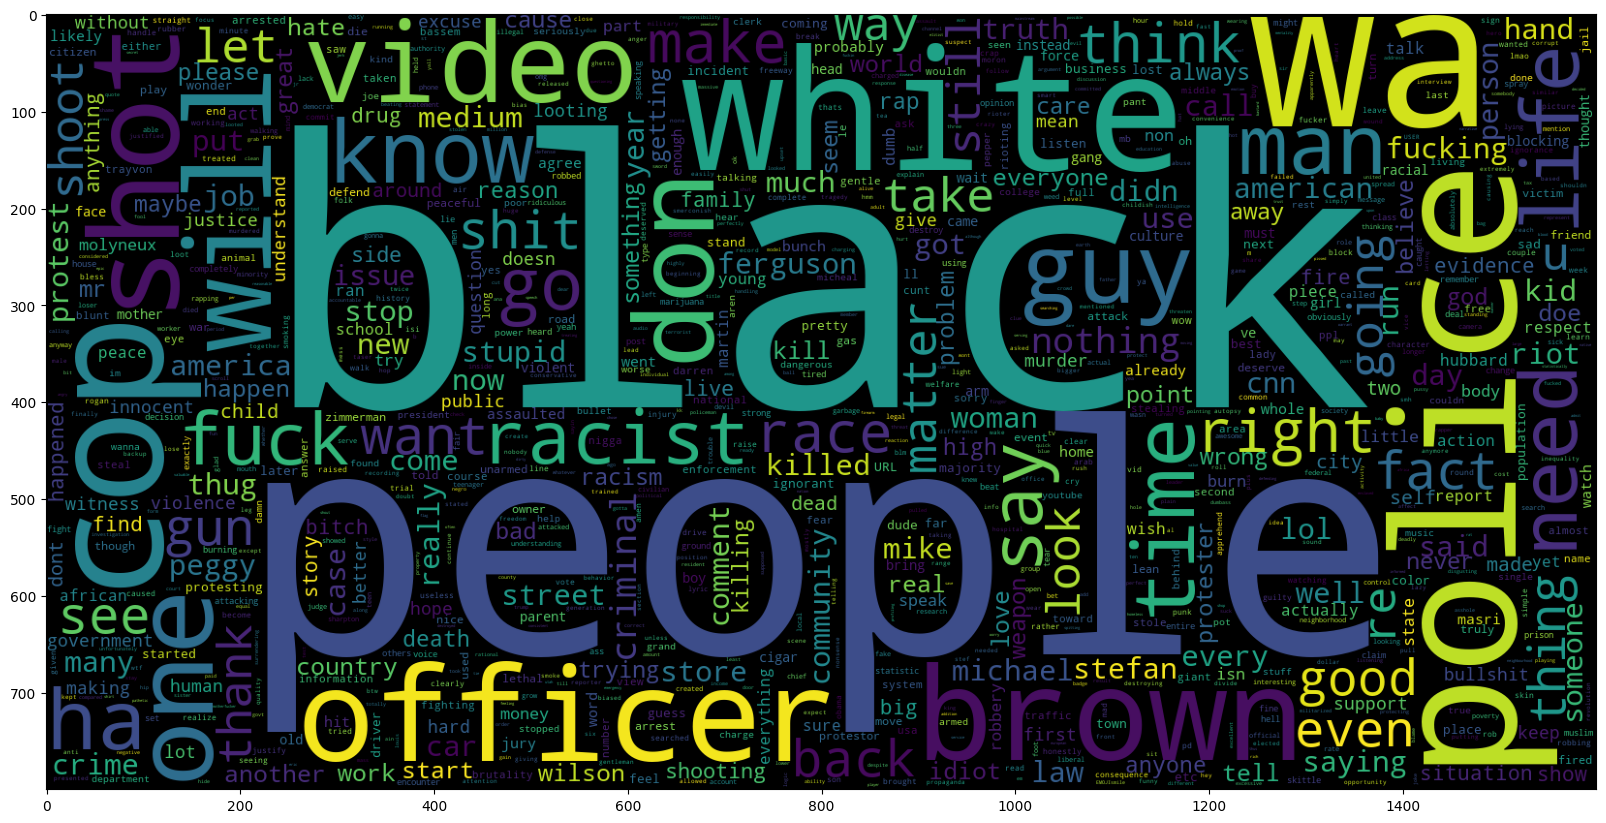

In [11]:
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

# DATA SPLIT

In [12]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, istoxic,
                                                    test_size = 0.20, random_state = 0)
print(f'Data Split done.')

Data Split done.


## Vectoriser

In [13]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
vectoriser.fit(X_test)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

filename_transformer = 'Vectoriser.pkl'
pickle.dump(vectoriser, open(filename_transformer, 'wb'))

Vectoriser fitted.
No. of feature_words:  6676


c:\Users\DooFromash\miniconda3\envs\nlp-app\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Tranforming the dataset
Transforming the X_train and X_test dataset into matrix of TF-IDF Features by using the TF-IDF Vectoriser. This datasets will be used to train the model and test against it.

In [14]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


# Creating and Evaluating Models

In [15]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    # Print the evaluation metrics for the dataset.
    print("Test", classification_report(y_test, y_pred))
    print("Train", classification_report(y_train, y_pred_train))
    
    # # Compute and plot the Confusion matrix
    # cf_matrix = confusion_matrix(y_test, y_pred)

    # categories  = ['Negative','Positive']
    # group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    # group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    # labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    # labels = np.asarray(labels).reshape(2,2)

    # sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    #             xticklabels = categories, yticklabels = categories)

    # plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    # plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    # plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

# BernoulliNB Model

In [16]:

BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

Test               precision    recall  f1-score   support

           0       0.58      0.76      0.66       103
           1       0.62      0.41      0.49        97

    accuracy                           0.59       200
   macro avg       0.60      0.58      0.57       200
weighted avg       0.60      0.59      0.58       200

Train               precision    recall  f1-score   support

           0       0.64      1.00      0.78       435
           1       1.00      0.34      0.51       365

    accuracy                           0.70       800
   macro avg       0.82      0.67      0.65       800
weighted avg       0.81      0.70      0.66       800



# LinearSVC Model

In [17]:

SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

Test               precision    recall  f1-score   support

           0       0.63      0.85      0.72       103
           1       0.75      0.46      0.57        97

    accuracy                           0.67       200
   macro avg       0.69      0.66      0.65       200
weighted avg       0.69      0.67      0.65       200

Train               precision    recall  f1-score   support

           0       0.98      1.00      0.99       435
           1       1.00      0.98      0.99       365

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



In [18]:
np.abs(((85 - 100)/85) *100)

17.647058823529413

# Logistic Regression Model

In [19]:

LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

Test               precision    recall  f1-score   support

           0       0.62      0.90      0.73       103
           1       0.80      0.40      0.53        97

    accuracy                           0.66       200
   macro avg       0.71      0.65      0.63       200
weighted avg       0.70      0.66      0.64       200

Train               precision    recall  f1-score   support

           0       0.94      0.97      0.95       435
           1       0.97      0.92      0.94       365

    accuracy                           0.95       800
   macro avg       0.95      0.95      0.95       800
weighted avg       0.95      0.95      0.95       800



# Multinomial Naive Bayes

In [20]:

mnb = MultinomialNB()

mnb.fit(X_train, y_train)
model_Evaluate(mnb)

Test               precision    recall  f1-score   support

           0       0.64      0.84      0.73       103
           1       0.75      0.51      0.60        97

    accuracy                           0.68       200
   macro avg       0.70      0.67      0.67       200
weighted avg       0.70      0.68      0.67       200

Train               precision    recall  f1-score   support

           0       0.84      0.98      0.90       435
           1       0.97      0.77      0.86       365

    accuracy                           0.88       800
   macro avg       0.90      0.87      0.88       800
weighted avg       0.90      0.88      0.88       800



In [21]:
#Cross Validation
from sklearn.model_selection import cross_val_score
cross_val_score(mnb, X_train, y_train, scoring='recall', cv=5).mean()

0.41369863013698627

# Grid Search CV

In [22]:
n_classes = X_train.shape[1], np.unique(y_train)

In [23]:
%%time

params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0, ],
          'fit_prior': [True, False],
          'class_prior': [None, [0.1,]* len(n_classes), ]
         }

multinomial_nb_grid = GridSearchCV(MultinomialNB(), param_grid=params, n_jobs=-1, cv=5, verbose=5)
multinomial_nb_grid.fit(X_train,y_train)

print('Best Accuracy Through Grid Search : {:.3f}'.format(multinomial_nb_grid.best_score_))
print('Best Parameters : {}\n'.format(multinomial_nb_grid.best_params_))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Accuracy Through Grid Search : 0.677
Best Parameters : {'alpha': 0.5, 'class_prior': None, 'fit_prior': True}

CPU times: total: 297 ms
Wall time: 3.17 s


In [24]:
from sklearn.metrics import classification_report, accuracy_score
y_preds = multinomial_nb_grid.best_estimator_.predict(X_test)
y_preds_train = multinomial_nb_grid.best_estimator_.predict(X_train)

print("Test Accuracy Score : {:.3f}".format(accuracy_score(y_test, y_preds)))
print("Train Accuracy Score : {:.3f}".format(accuracy_score(y_train, y_preds_train)))
print("\nTEST Classification Report :")
print(classification_report(y_test, y_preds))

Test Accuracy Score : 0.690
Train Accuracy Score : 0.907

TEST Classification Report :
              precision    recall  f1-score   support

           0       0.66      0.81      0.73       103
           1       0.73      0.57      0.64        97

    accuracy                           0.69       200
   macro avg       0.70      0.69      0.68       200
weighted avg       0.70      0.69      0.69       200



In [25]:
np.abs(((0.69  - 0.87)/0.69) *100)

26.08695652173914

In [26]:
filename = 'MultinomialNB_NLP.pkl'
pickle.dump(multinomial_nb_grid, open(filename, 'wb'))

In [27]:
loaded_model = pickle.load(open(filename,'rb'))
loaded_model.predict(X_test)

array([1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1], dtype=uint8)

In [32]:
loaded_model = pickle.load(open(filename_transformer,'rb'))
loaded_model.transform('hello world')

ValueError: Iterable over raw text documents expected, string object received.